## Task G: Contrast sensitivity function of photo

### Load the photo

L:  256
I_2d.shape:  (256, 256)


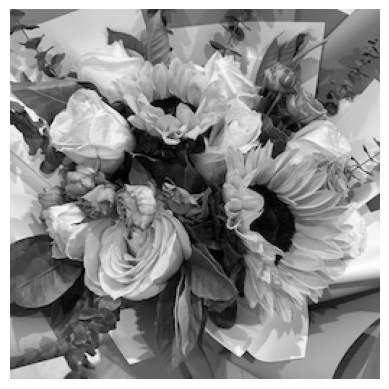

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np  
import os

figures_dir = image_path = os.path.join("..", "figures")

image_name_list = [f"p{i}.jpg" for i in range(1,8)]

I_list = []
for image_name in image_name_list:
    image_path = os.path.join(figures_dir, image_name)
    I = Image.open(image_path).convert('L')  # 'L' means the gray scale
    I = np.array(I)
    I_list.append(I)

L = I_list[0].shape[0] 
print("L: ", L)


I_2d = I_list[0]
print("I_2d.shape: ", I_2d.shape)

plt.imshow(I_2d, cmap='gray')  # show the image
plt.axis('off')     # turn down the axis
plt.show()


### 1.1 Define $S_c(x,y)$, S_s(x,y) and $S'(x,y)$

$S(x,y)$ is the grayscale value of the photo

$$S'(x,y)=\left\{
\begin{array}{lr}
	S(x, y), &\text{when}\ x\le x_{max}\\
	S(x', y), &\text{when}\ x>x_{max}, \text{here}\ x' = x_{max} - (x - x_{max})
\end{array}
\right.$$


$$S_c(k) = \sum S'(x,y)\cos(kx)$$

$$S_s(k) = \sum S'(x,y)\sin(kx)$$

$$|S(k)|^2 = [S_c(k)]^2 + [S_s(k)]^2$$




In [2]:
from math import exp, cos, sin, pi

# Width = I_2d.shape[1]  # width of the image
# Height = I_2d.shape[0] # height of the image

def S(x,y,I):
    j = np.int32(x + L/2) - 1
    i = np.int32(L/2 - y)
    S = I[i,j]
    return S

def S_prime(x,y, I):
    if abs(x) <= L/2:
        return S(x,y,I)
    else:
        x_prime = L/2 - (x - L/2)
        return S(x_prime,y,I)

def get_kernel_S_prime(I):
    '''Difference of Signal kernel (with extensions)'''
    M = np.zeros((L, L*2))
    for i in range(L):
        y = L/2 - i
        for j in range(L*2):
            x = j - L/2 + 1
            M[i,j] += S_prime(x,y,I)
    return M


def S_s_K(k, kernel):
    S_s = 0
    for i in range(L):
        for j in range(kernel.shape[1]):
            x = j - L/2
            S_s += kernel[i,j] * sin(k * x)
    return S_s

def S_c_K(k, kernel):
    S_c = 0
    for i in range(L):
        for j in range(kernel.shape[1]):
            x = j - L/2
            S_c += kernel[i,j] * cos(k * x)
    return S_c

def S_K_square(k, kernel):
    S_K_square = S_s_K(k, kernel)**2 + S_c_K(k, kernel)**2
    return S_K_square

### 1.2 For an instance, plot the receptive field and normalize

In [3]:
# get the signal kernel
kernel_1 = get_kernel_S_prime(I_list[0])

In [4]:
kernel_normalized_1 = (kernel_1 - np.mean(kernel_1)) / np.std(kernel_1)
kernel_normalized_1 = kernel_normalized_1/np.max(np.abs(kernel_normalized_1))

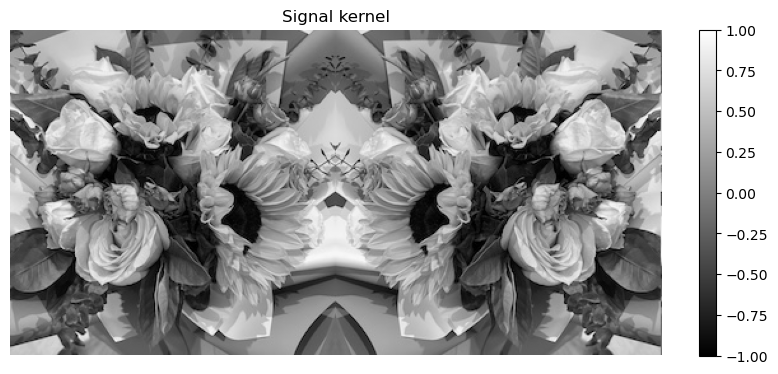

In [5]:
plt.figure(figsize=(10, 4))
plt.imshow(kernel_normalized_1, cmap='gray', vmin=-1, vmax=1)
plt.title(f"Signal kernel")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.axis('off')
plt.show()

### 1.3 For all photos, average and plot the contrast sensitivity function

In [7]:
from tqdm import tqdm
k_list = [n*2*pi /(2* L) for n in range(L+1)]

all_s_square_list = []

for idx, I_2d in enumerate(I_list):
    kernel = get_kernel_S_prime(I_2d)
    kernel_normalized = (kernel - np.mean(kernel)) / np.std(kernel)
    kernel_normalized = kernel_normalized/np.max(np.abs(kernel_normalized))
    
    s_square_list = []
    for k in tqdm(k_list, total=len(k_list), desc=f"Computing S_K^2 for image {idx}"):
        s_square_list.append(S_K_square(k, kernel_normalized))
    
    all_s_square_list.append(s_square_list)


Computing S_K^2 for image 6: 100%|██████████| 257/257 [00:15<00:00, 16.75it/s]


In [58]:
M_all_s_square = np.array(all_s_square_list)  # shape: (num_images, len(k_list))
col_mean = np.mean(M_all_s_square, axis=0)  # shape: (len(k_list),)

k_square_reverse = np.array([1/k**2 for k in k_list if k != 0])

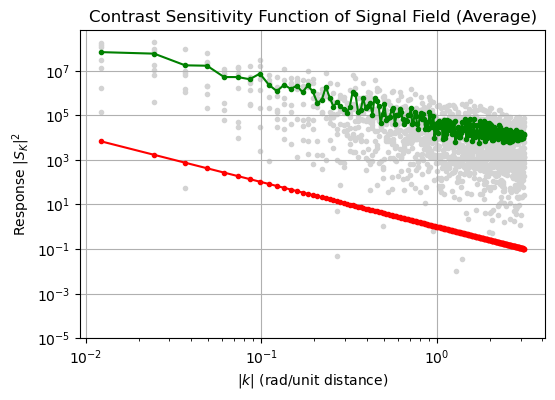

In [ ]:
plt.figure(figsize=(6,4))

for row in M_all_s_square:
    plt.scatter(k_list[1:], row[1:], color='lightgray', zorder=1, marker='.')

plt.plot(k_list[1:], col_mean[1:], marker='.', color='green', zorder=3)
plt.plot(k_list[1:], k_square_reverse, marker='.', color='red', zorder=3)

plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-5)
plt.xlabel("$|k|$ (rad/unit distance)")
plt.ylabel("Response $|S_K|^2$")
plt.title("Contrast Sensitivity Function of Signal Field (Average)")
plt.grid()
plt.savefig(os.path.join(figures_dir, f"Signal_CSF_average.pdf"), bbox_inches='tight', pad_inches=0.1)
plt.show()



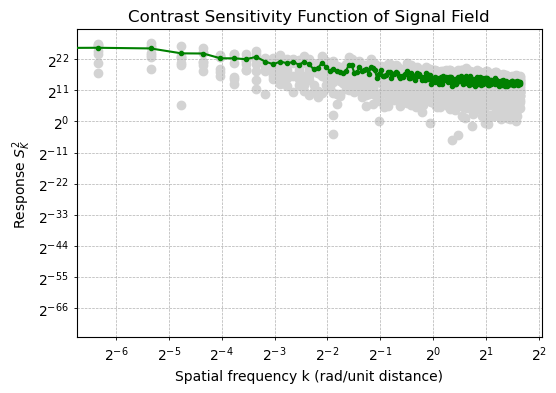

In [28]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.ticker import LogLocator, FuncFormatter

# plt.figure(figsize=(6,4))

# for row in M_all_s_square:
#     plt.scatter(k_list, row, color='lightgray', zorder=1)

# plt.plot(k_list, col_mean, marker='.', color='green', zorder=3)

# # 设置 x 轴 log2
# plt.xscale('log', base=2)
# plt.gca().xaxis.set_major_locator(LogLocator(base=2, subs=None))  # 主要刻度：2^n
# plt.gca().xaxis.set_minor_locator(LogLocator(base=2, subs=np.arange(2, 2), numticks=10))  # 不显示次刻度
# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda val, _: r"$2^{%d}$" % int(np.log2(val))))

# # 设置 y 轴 log2
# plt.yscale('log', base=2)
# plt.gca().yaxis.set_major_locator(LogLocator(base=2, subs=None))  # 主要刻度：2^n
# plt.gca().yaxis.set_minor_locator(LogLocator(base=2, subs=np.arange(2, 2), numticks=10))  # 不显示次刻度
# plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda val, _: r"$2^{%d}$" % int(np.log2(val))))

# plt.xlabel("Spatial frequency k (rad/unit distance)")
# plt.ylabel("Response $S_K^2$")
# plt.title("Contrast Sensitivity Function of Signal Field")
# plt.grid(True, which="both", ls="--", lw=0.5)
# plt.show()